# Трансферное обучение и тонкая настройка


В этом уроке вы узнаете, как классифицировать изображения кошек и собак с помощью трансферного обучения на основе предварительно обученной сети.

Предварительно обученная модель - это сохраненная сеть, которая была предварительно обучена на большом наборе данных, обычно на крупномасштабной задаче классификации изображений. Вы либо используете предварительно обученную модель как есть, либо применяете трансферное обучение, чтобы адаптировать эту модель к конкретной задаче.

Интуиция, лежащая в основе трансферного обучения для классификации изображений, заключается в том, что если модель обучена на достаточно большом и общем наборе данных, то эта модель будет эффективно служить общей моделью визуального мира. Затем вы можете воспользоваться преимуществами этих выученных карт признаков без необходимости начинать с нуля, обучая большую модель на большом наборе данных.

В этом блокноте вы попробуете два способа настройки предварительно обученной модели:

1. Извлечение признаков: Используйте представления, полученные предыдущей сетью, для извлечения значимых признаков из новых образцов. Вы просто добавляете новый классификатор, который будет обучен с нуля, поверх предварительно обученной модели, чтобы можно было использовать ранее выученные карты признаков для данного набора данных.

 Вам не нужно (заново) обучать всю модель. Базовая конволюционная сеть уже содержит признаки, которые в общем случае полезны для классификации изображений. Однако конечная, классификационная часть предварительно обученной модели специфична для исходной задачи классификации, а впоследствии и для набора классов, на которых обучалась модель.

1. Тонкая настройка: Разморозьте несколько верхних слоев замороженной базовой модели и совместно обучите как вновь добавленные слои классификатора, так и последние слои базовой модели. Это позволит нам «тонко настроить» представления признаков высшего порядка в базовой модели, чтобы сделать их более релевантными для конкретной задачи.

Вы будете следовать общему процессу машинного обучения.

1. Изучение и понимание данных
1. Постройте входной конвейер, в данном случае с помощью Keras ImageDataGenerator
1. Составьте модель
   * Загрузите предварительно обученную базовую модель (и предварительно обученные веса)
   * Складываем слои классификации сверху
1. Обучите модель
1. Оценить модель

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Предварительная обработка данных

### Загрузка данных

In [25]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [26]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Покажите первые девять изображений и метки из обучающего набора:

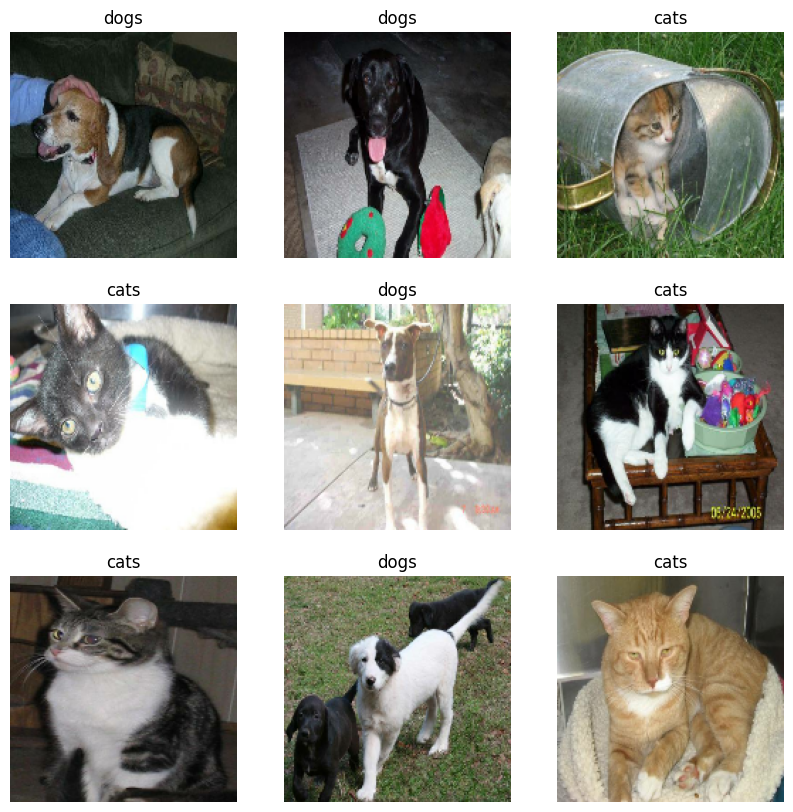

In [27]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Поскольку исходный набор данных не содержит тестового набора, вам предстоит его создать. Для этого определите, сколько партий данных имеется в наборе для проверки, используя `tf.data.experimental.cardinality`, а затем перенесите 20% из них в тестовый набор.

In [29]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [30]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### Настройте набор данных на производительность

Используйте буферизованную предварительную выборку для загрузки изображений с диска без блокировки ввода-вывода.

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Используйте расширение данных

Если у вас нет большого набора данных изображений, целесообразно искусственно внести разнообразие в выборку, применяя к обучающим изображениям случайные, но реалистичные преобразования, такие как поворот и горизонтальное переворачивание. Это помогает познакомить модель с различными аспектами обучающих данных и уменьшить overfitting

In [32]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Примечание: Эти слои активны только во время обучения, когда вы вызываете `Model.fit`. Они неактивны, когда модель используется в режиме вывода в `Model.evaluate`, `Model.predict` или `Model.call`.

Давайте несколько раз применим эти слои к одному и тому же изображению и посмотрим на результат.

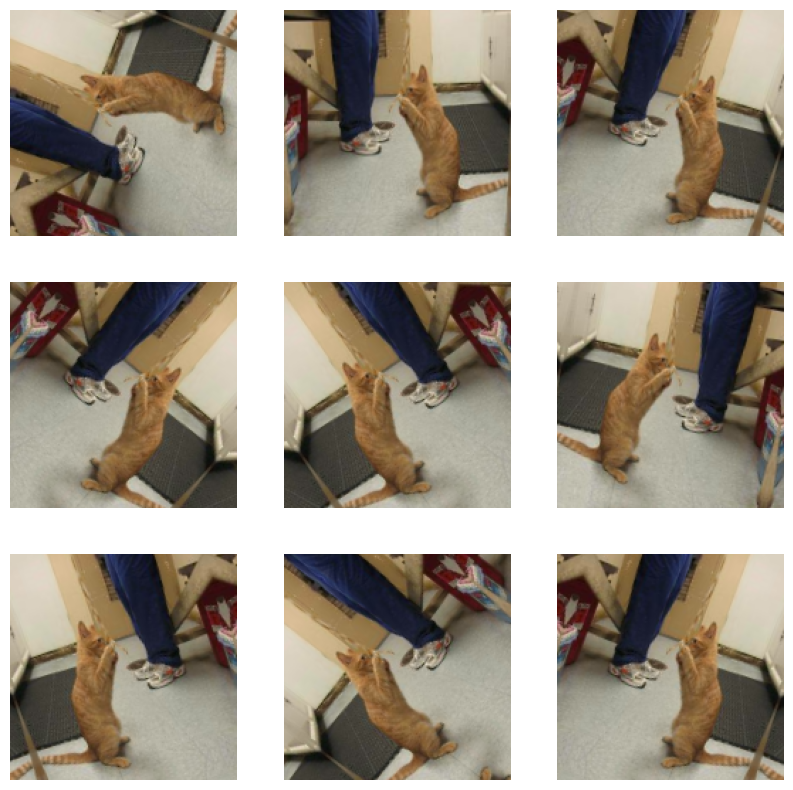

In [33]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Изменение масштаба значений пикселей

Через некоторое время вы загрузите `tf.keras.applications.MobileNetV2` для использования в качестве базовой модели. Эта модель ожидает значения пикселей в `[-1, 1]`, но на данный момент значения пикселей на ваших изображениях находятся в `[0, 255]`. Чтобы изменить их масштаб, воспользуйтесь методом предварительной обработки, входящим в комплект модели.

In [34]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Примечание: В качестве альтернативы можно изменить масштаб значений пикселей с `[0, 255]` на `[-1, 1]`, используя `tf.keras.layers.Rescaling`.

In [35]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Примечание: Если вы используете другие приложения `tf.keras.applications`, обязательно проверьте в документации API, чтобы определить, ожидают ли они пиксели в `[-1, 1]` или `[0, 1]`, или используйте включенную функцию `preprocess_input`.

## Создайте базовую модель из предварительно обученных коннетов
Вы создадите базовую модель на основе модели **MobileNet V2**, разработанной в Google. Она предварительно обучена на наборе данных ImageNet, большом наборе данных, состоящем из 1,4 млн изображений и 1000 классов. ImageNet - это исследовательский обучающий набор данных с широким спектром категорий, таких как `jackfruit` и `syringe`. Эта база знаний поможет нам классифицировать кошек и собак на основе нашего конкретного набора данных.

Сначала нужно выбрать, какой слой MobileNet V2 вы будете использовать для извлечения признаков. Самый последний слой классификации (на «вершине», так как большинство диаграмм моделей машинного обучения идут снизу вверх) не очень полезен. Вместо этого, следуя общепринятой практике, вы будете зависеть от самого последнего слоя перед операцией сглаживания. Этот слой называется «слоем узкого места». Функции «узкого места» сохраняют больше общности по сравнению с последним/верхним слоем.

Сначала создайте модель MobileNet V2, предварительно загрузив в нее веса, обученные на ImageNet. Указав аргумент **include_top=False**, вы загружаете сеть, которая не включает классификационные слои в верхней части, что идеально подходит для извлечения признаков.

In [36]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Этот экстрактор признаков преобразует каждое изображение `160x160x3` в блок признаков `5x5x1280`. Давайте посмотрим, что он делает с примерами изображений:

In [37]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Извлечение признаков
На этом шаге вы заморозите конволюционную базу, созданную на предыдущем шаге, и используете ее в качестве экстрактора признаков. Кроме того, вы добавляете классификатор поверх нее и обучаете классификатор верхнего уровня.

### Заморозить базу конволюции

Важно заморозить конволюционную базу перед компиляцией и обучением модели. Замораживание (путем установки layer.trainable = False) предотвращает обновление весов в данном слое во время обучения. В MobileNet V2 много слоев, поэтому установка флага `trainable` всей модели в значение False приведет к замораживанию всех слоев.

In [38]:
base_model.trainable = False

### Важное замечание о слоях BatchNormalization

Многие модели содержат слои `tf.keras.layers.BatchNormalization`. Этот слой является особым случаем, и с ним следует соблюдать меры предосторожности в контексте тонкой настройки, как показано далее в этом руководстве.

Если задать `layer.trainable = False`, слой `BatchNormalization` будет работать в режиме вывода и не будет обновлять статистику среднего и дисперсии.

Когда вы размораживаете модель, содержащую слои пакетной нормализации, чтобы выполнить тонкую настройку, вы должны держать слои пакетной нормализации в режиме вывода, передавая `training = False` при вызове базовой модели. В противном случае обновления, примененные к необучаемым весам, разрушат то, чему научилась модель.

In [39]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 80, 80, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 80, 80, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 80, 80, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 80, 80, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 80, 80, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 80, 80, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 81, 81, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 40, 40, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### Добавить голову классификации

Чтобы получить предсказания по блоку признаков, усредните их по пространственным расположениям `5x5`, используя слой `tf.keras.layers.GlobalAveragePooling2D` для преобразования признаков в один вектор из 1280 элементов для каждого изображения.

In [40]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Примените слой `tf.keras.layers.Dense` для преобразования этих признаков в одно предсказание для каждого изображения. Функция активации здесь не нужна, потому что это предсказание будет рассматриваться как `logit`, или необработанное значение предсказания. Положительные числа предсказывают класс 1, отрицательные - класс 0.

In [41]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Постройте модель, объединив в цепочку слои `наращивания данных`, `ремасштабирования`, `базовой_модели` и экстрактора признаков с помощью [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). Как уже говорилось ранее, используйте `training=False`, поскольку наша модель содержит слой `BatchNormalization`.

In [42]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [43]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

8 с лишним миллионов параметров MobileNet заморожены, но в слое Dense есть 1,2 тысячи _обучаемых_ параметров. Они разделены между двумя объектами `tf.Variable`, весами и смещениями.

In [44]:
len(model.trainable_variables)

2

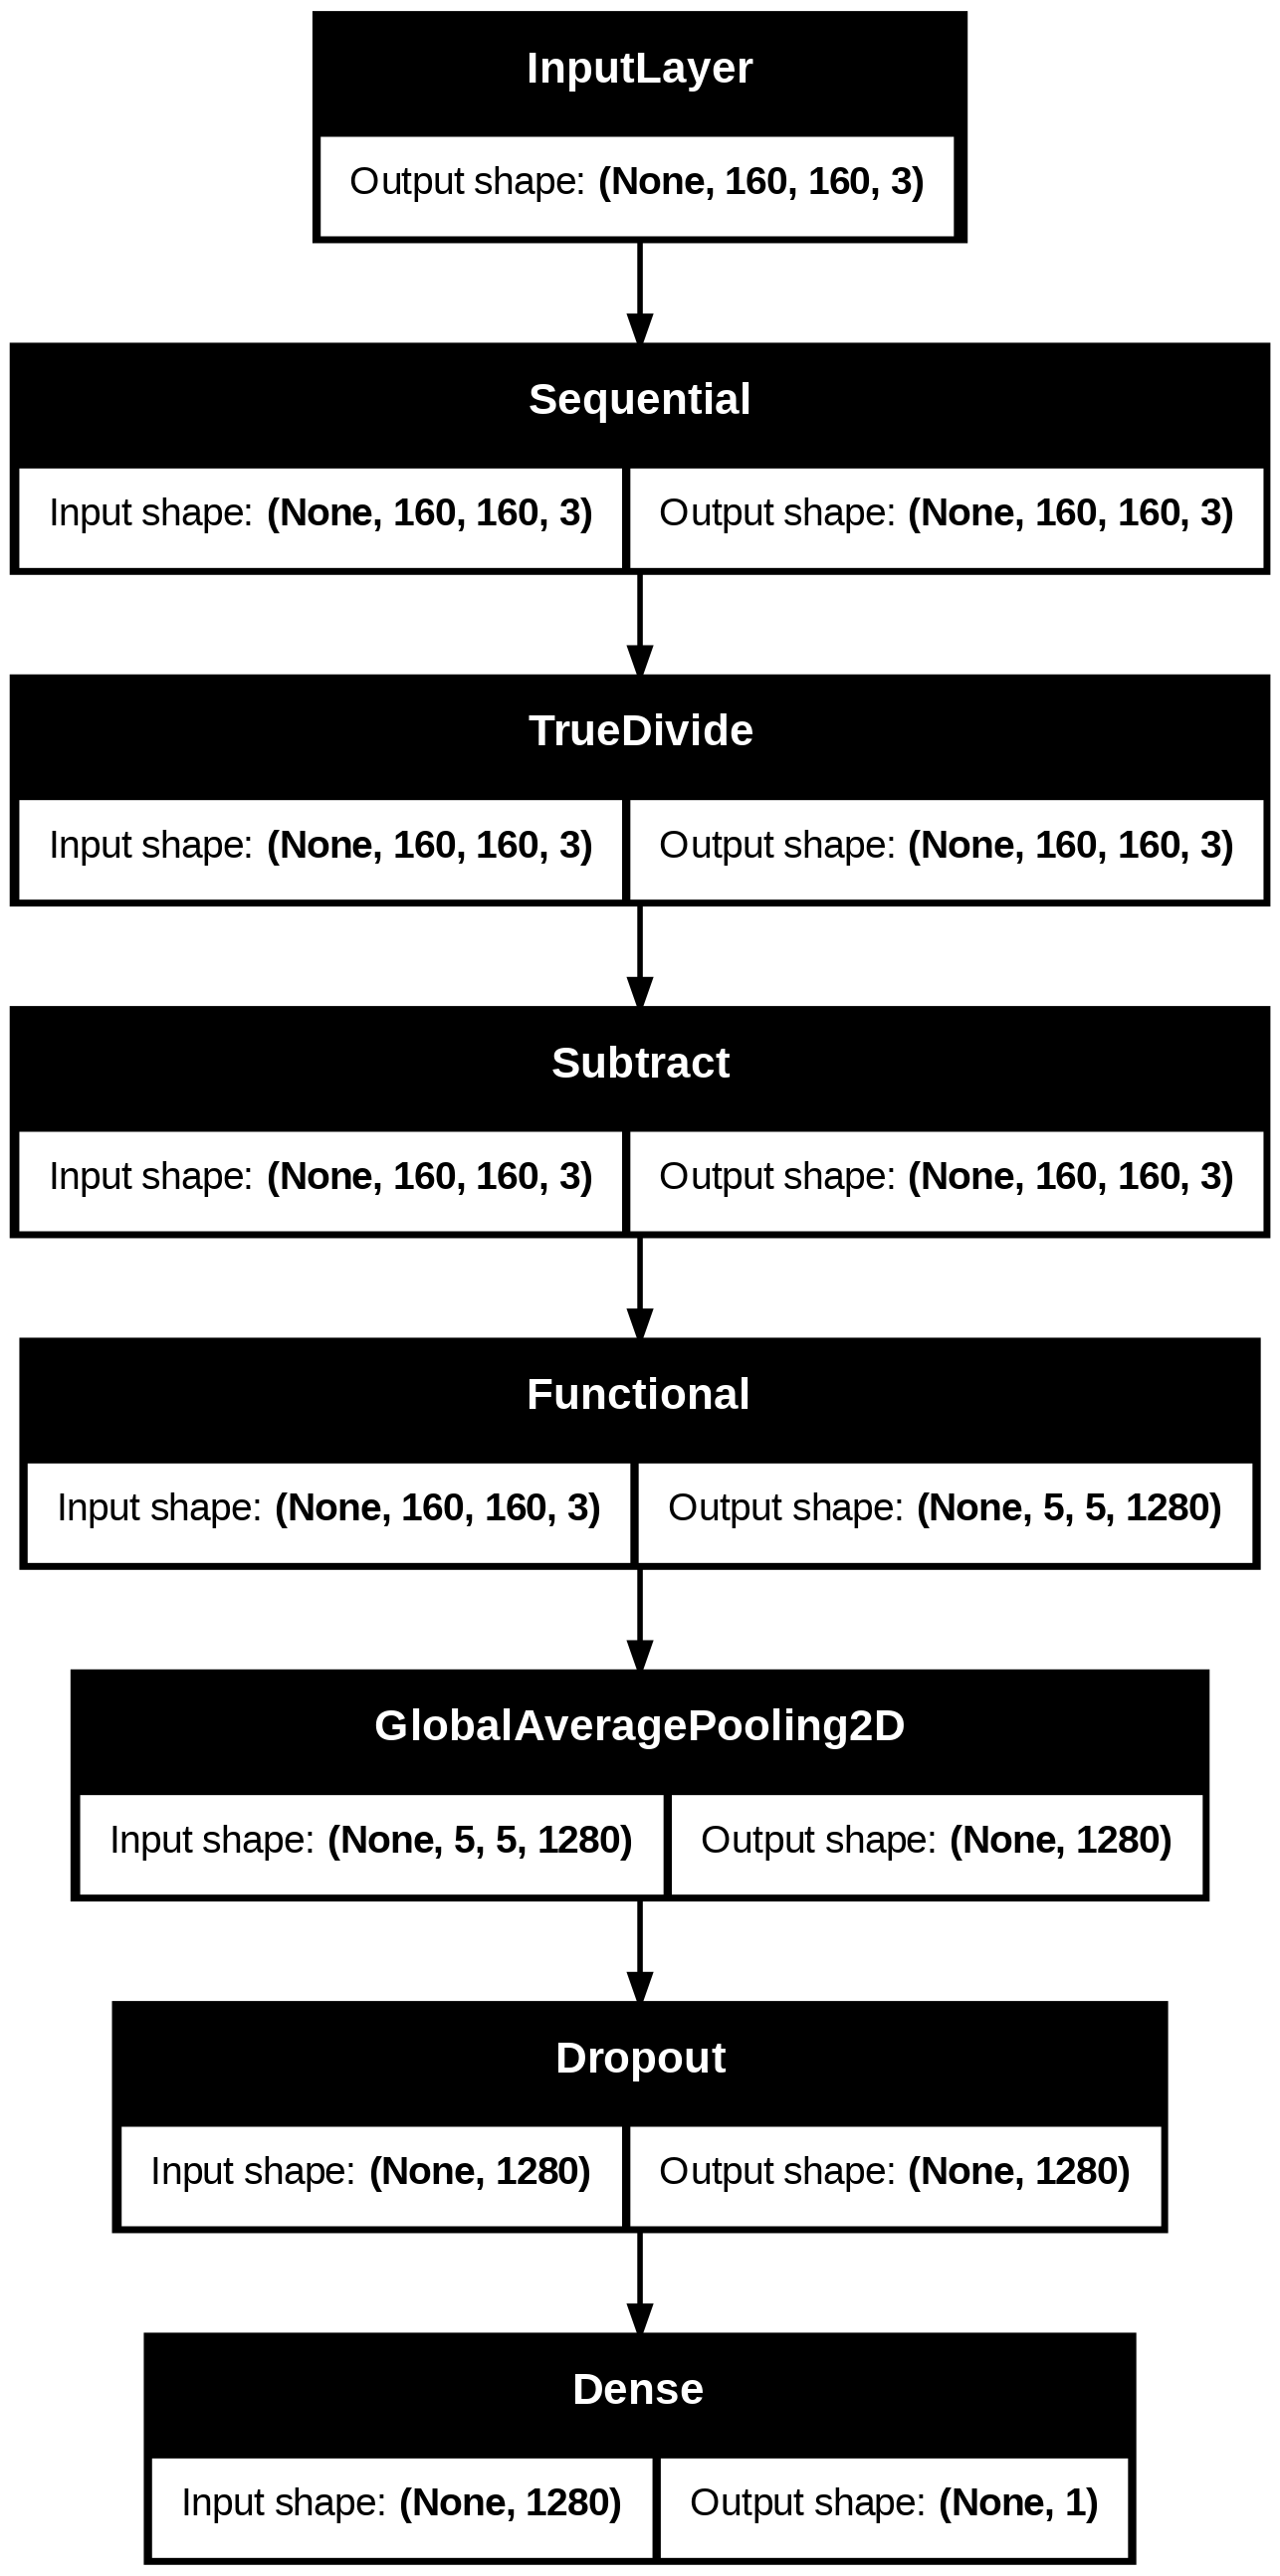

In [45]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Компиляция модели

Скомпилируйте модель перед ее обучением. Поскольку имеется два класса и сигмоидальный вывод, используйте `BinaryAccuracy`.

In [46]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

### Обучение модели

После обучения в течение 10 эпох вы должны увидеть ~96% точности на валидационном множестве.

In [47]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5585 - loss: 0.7168


In [48]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.71
initial accuracy: 0.58


In [49]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.5775 - loss: 0.7181 - val_accuracy: 0.7735 - val_loss: 0.4838
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7302 - loss: 0.5416 - val_accuracy: 0.8676 - val_loss: 0.3583
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8276 - loss: 0.4094 - val_accuracy: 0.9183 - val_loss: 0.2817
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.8683 - loss: 0.3440 - val_accuracy: 0.9431 - val_loss: 0.2293
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.8792 - loss: 0.3109 - val_accuracy: 0.9579 - val_loss: 0.1996
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9090 - loss: 0.2724 - val_accuracy: 0.9666 - val_loss: 0.1747
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9158 - loss: 0.2510 - val_accuracy: 0.9653 - val_loss: 0.1632
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8975 - loss: 0.2538 - val_accuracy: 0.9703 - 

### Кривые обучения

Давайте посмотрим на кривые обучения точности/потери при обучении и проверке при использовании базовой модели MobileNetV2 в качестве фиксированного экстрактора признаков.

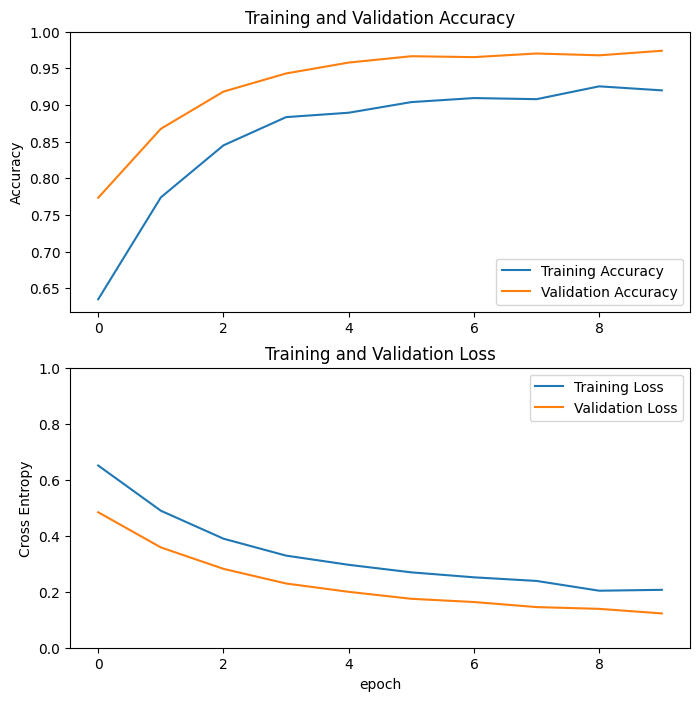

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Примечание: Если вы задаетесь вопросом, почему метрики проверки явно лучше метрик обучения, то основной фактор заключается в том, что такие слои, как `tf.keras.layers.BatchNormalization` и `tf.keras.layers.Dropout` влияют на точность во время обучения. Они отключаются при расчете потерь при валидации.

В меньшей степени это связано с тем, что метрики обучения показывают среднее значение за эпоху, а метрики валидации оцениваются после эпохи, поэтому метрики валидации видят модель, которая обучалась немного дольше.

## Тонкая настройка
В эксперименте по извлечению признаков вы обучали только несколько слоев поверх базовой модели MobileNetV2. Веса предварительно обученной сети **не** обновлялись во время обучения.

Один из способов еще больше повысить производительность - обучить (или «тонко настроить») веса верхних слоев предварительно обученной модели одновременно с обучением добавленного классификатора. В процессе обучения весовые коэффициенты будут настраиваться от общих карт признаков к признакам, связанным с конкретным набором данных.

Примечание: Это следует делать только после обучения классификатора верхнего уровня, а для предварительно обученной модели установлено значение «не поддается обучению». Если вы добавите классификатор со случайной инициализацией поверх предварительно обученной модели и попытаетесь обучить все слои совместно, величина обновлений градиента будет слишком большой (из-за случайных весов классификатора), и предварительно обученная модель забудет, чему она научилась.

Кроме того, следует пытаться настраивать небольшое количество верхних слоев, а не всю модель MobileNet. В большинстве конволюционных сетей чем выше слой, тем он более специализирован. Первые несколько слоев изучают очень простые и общие признаки, которые применимы почти ко всем типам изображений. По мере продвижения вверх слои становятся все более специфичными для набора данных, на котором обучалась модель. Цель тонкой настройки - адаптировать эти специализированные признаки для работы с новым набором данных, а не переписать общие.

### Разморозьте верхние слои модели


Все, что вам нужно сделать, это разморозить `base_model` и установить нижние слои необучаемыми. Затем следует перекомпилировать модель (это необходимо для того, чтобы эти изменения вступили в силу) и возобновить обучение.


In [51]:
base_model.trainable = True

In [52]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Компиляция модели

Поскольку вы обучаете гораздо более крупную модель и хотите переадаптировать предварительно обученные веса, на этом этапе важно использовать более низкую скорость обучения. В противном случае модель может очень быстро перестроиться.


In [53]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [54]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [55]:
len(model.trainable_variables)

56

### Продолжаем обучение модели


Если вы тренировались сходиться раньше, этот шаг повысит точность на несколько процентов.


In [56]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.8037 - loss: 0.4249 - val_accuracy: 0.9740 - val_loss: 0.0847
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.8770 - loss: 0.2817 - val_accuracy: 0.9777 - val_loss: 0.0670
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.9116 - loss: 0.2276 - val_accuracy: 0.9790 - val_loss: 0.0576
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9333 - loss: 0.1847 - val_accuracy: 0.9839 - val_loss: 0.0500
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.9399 - loss: 0.1689 - val_accuracy: 0.9851 - val_loss: 0.0479
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.9428 - loss: 0.1571 - val_accuracy: 0.9839 - val_loss: 0.0468
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.9438 - loss: 0.1434 - val_accuracy: 0.9876 - val_loss: 0.0397
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.9457 - loss: 0.1371 - val_accuracy: 

Давайте посмотрим на кривые обучения точности/потерь при обучении и проверке при тонкой настройке последних нескольких слоев базовой модели MobileNetV2 и обучении классификатора на ее основе. Потери при проверке значительно выше потерь при обучении, поэтому вы можете получить некоторую перегрузку.

Вы также можете получить некоторую избыточную подгонку, поскольку новый набор данных для обучения относительно мал и похож на оригинальные наборы данных MobileNetV2.

После тонкой настройки модель достигает точности 98% на валидационном множестве.

In [57]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

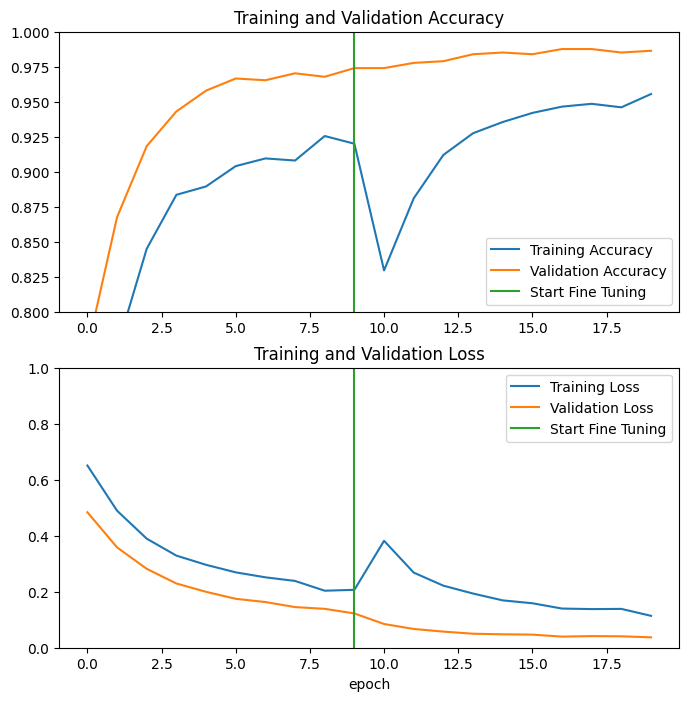

In [58]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Оценка и прогнозирование

Наконец, вы можете проверить работу модели на новых данных с помощью тестового набора.

In [59]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9716 - loss: 0.0512
Test accuracy : 0.96875


И теперь вы можете использовать эту модель, чтобы предсказать, кто ваш питомец - кошка или собака.

Predictions:
 [1 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1]
Labels:
 [1 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1]


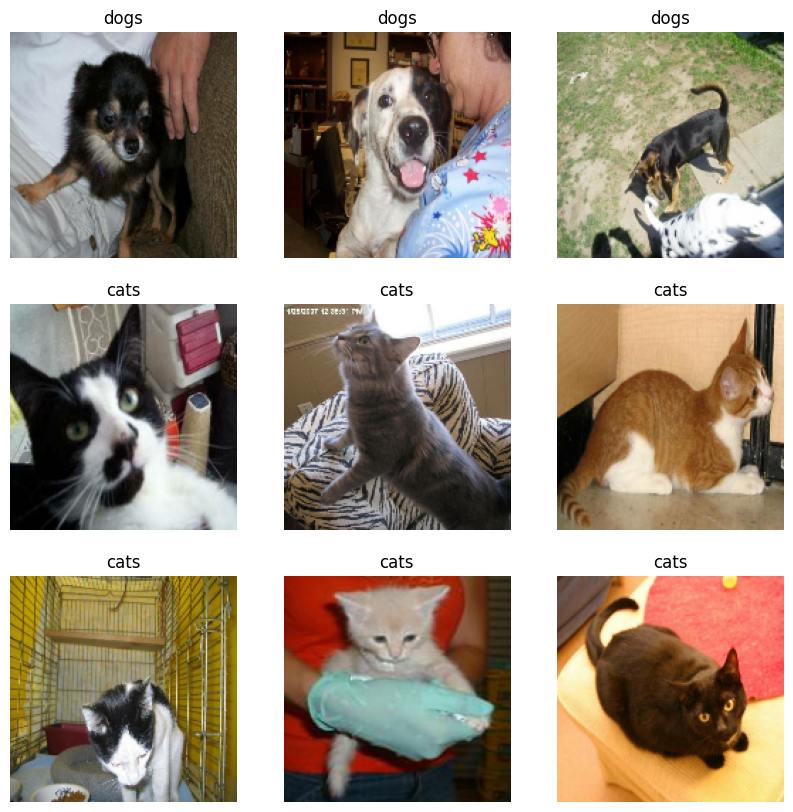

In [60]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Резюме

* **Использование предварительно обученной модели для извлечения признаков**:  При работе с небольшим набором данных часто используется возможность извлечения признаков из модели, обученной на более крупном наборе данных в той же области. Это делается путем инстанцирования предварительно обученной модели и добавления сверху полносвязного классификатора. Предварительно обученная модель «замораживается», и в процессе обучения обновляются только веса классификатора.
В данном случае конволюционная база извлекает все признаки, связанные с каждым изображением, и вы только что обучили классификатор, который определяет класс изображения по этому набору извлеченных признаков.

* **Точная настройка предварительно обученной модели**: Чтобы еще больше повысить производительность, можно перенастроить верхние слои предварительно обученной модели на новый набор данных с помощью тонкой настройки.
В данном случае вы настроили веса таким образом, чтобы модель обучалась высокоуровневым признакам, специфичным для данного набора данных. Эта техника обычно рекомендуется, когда обучающий набор данных большой и очень похож на исходный набор данных, на котором обучалась предварительно обученная модель.